In [1]:
#*Universidad Peruana de Ciencias Aplicadas. *

In [2]:
#Curso: Talleres Docente: Carlos Fernando Montoya Cubas.

In [3]:
#*Trabajo Final *

In [4]:
#Clasificación de Imágenes de Gatos y Perros

In [5]:
#Fuente: https://www.kaggle.com/code/demko1/cat-dog-clasification/input

In [6]:
#Integrantes:

#Amalia Roscío Villena Romaní
#Leonardo Daniel Ramirez Galindo

In [7]:
#Objetivo: Desarrollar un sistema de clasificación binaria de imágenes (gatos vs perros) 
#mediante redes convolucionales profundas, incorporando técnicas de data augmentation, regularización, 
#fine-tuning de modelos preentrenados y explicabilidad visual (Grad-CAM), con una app interactiva desplegada online.

In [8]:
#1.- Definición del Problema

In [9]:
#"Problema del negocio: Empresas de adopción de mascotas, plataformas sociales o apps móviles requieren un sistema que clasifique automáticamente imágenes de mascotas (gato o perro) subidas por los usuarios, garantizando velocidad, precisión y explicabilidad visual.

#Tipo de problema: Clasificación binaria supervisada de imágenes.

#Justificación:

#Aprovechamos modelos de visión por computadora.

#Es un problema clásico con datasets públicos y benchmarking.

#Permite explorar desde CNN básicas hasta modelos preentrenados y Grad-CAM.

#Dataset:

#Dogs vs. Cats (Kaggle). Se procesará a:

#Entrenamiento (70%)
#Validación (15%)
#Prueba (15%)

In [10]:
#2.- Construcción del Modelo

In [11]:
#Descompresión y Organización de Archivos

In [13]:
import zipfile
import os
import shutil

def descomprimir_y_organizar(zip_path, target_dir):
    # Eliminar carpeta de destino si existe
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)
    
    # Descomprimir archivo ZIP
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_dir)
    
    # Verificar si hay subcarpetas anidadas (ej: training/training/cats)
    subfolder_path = os.path.join(target_dir, os.path.splitext(zip_path)[0])
    if os.path.exists(subfolder_path):
        # Mover subcarpetas a la raíz
        for folder in ["cats", "dogs"]:
            src = os.path.join(subfolder_path, folder)
            dest = os.path.join(target_dir, folder)
            if os.path.exists(src):
                shutil.move(src, dest)
        shutil.rmtree(subfolder_path)

# Ejecutar para training.zip y test.zip
descomprimir_y_organizar("training.zip", "training")
descomprimir_y_organizar("test.zip", "test")

In [ ]:
#Carga y Preprocesamiento de Datos (usando tf.data.Dataset)

In [14]:
import tensorflow as tf

# Cargar datasets con las nuevas rutas
train_dataset = tf.keras.utils.image_dataset_from_directory(
    'training',
    image_size=(150, 150),
    batch_size=32,
    label_mode='binary',  # 2 clases: cats (0) y dogs (1)
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    'test',
    image_size=(150, 150),
    batch_size=32,
    label_mode='binary'
)

# Normalización de píxeles (0-1)
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


In [ ]:
#Arquitectura de la CNN

In [15]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Regularización
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
#Entrenamiento con Callbacks

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=test_dataset,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/15


251/251 ━━━━━━━━━━━━━━━━━━━━ 102s 393ms/step - accuracy: 0.5554 - loss: 1.1295 - precision: 0.5385 - recall: 0.6440 - val_accuracy: 0.6545 - val_loss: 0.6268 - val_precision: 0.7325 - val_recall: 0.4872 - learning_rate: 0.0010
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 327ms/step - accuracy: 0.6957 - loss: 0.5956 - precision: 0.6984 - recall: 0.6801 - val_accuracy: 0.6698 - val_loss: 0.6191 - val_precision: 0.7014 - val_recall: 0.5919 - learning_rate: 0.0010
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 88s 348ms/step - accuracy: 0.7549 - loss: 0.5117 - precision: 0.7615 - recall: 0.7379 - val_accuracy: 0.7093 - val_loss: 0.5899 - val_precision: 0.7377 - val_recall: 0.6502 - learning_rate: 0.0010
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 94s 376ms/step - accuracy: 0.7980 - loss: 0.4172 - precision: 0.8090 - recall: 0.7726 - val_accuracy: 0.7074 - val_loss: 0.7106 - val_precision: 0.6810 - val_recall: 0.7806 - learning_rate: 0.0010
Epoch 5/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 87s 347ms/step - accur

In [17]:
# Guardar modelo para uso en Streamlit
model.save('modelo_gatos_perros.keras')

In [ ]:
#3.- Evaluación del Modelo

In [ ]:
# Métricas Clave

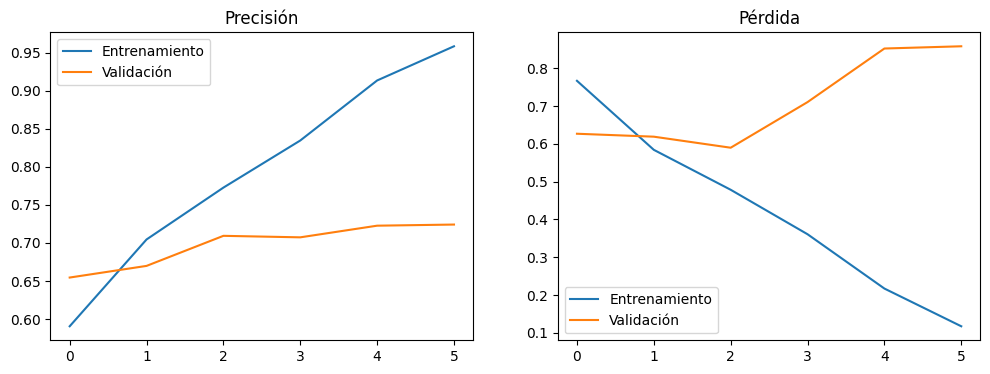

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

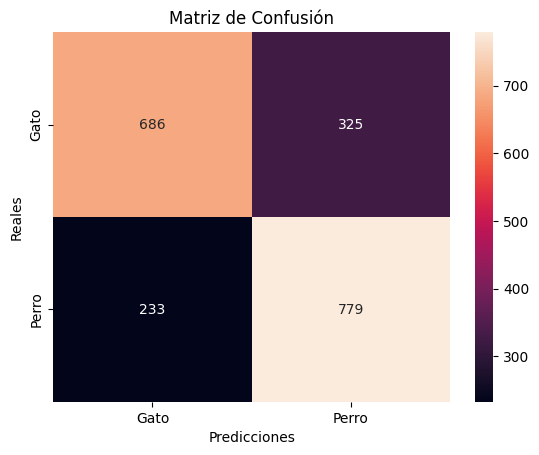

              precision    recall  f1-score   support

        Gato       0.75      0.68      0.71      1011
       Perro       0.71      0.77      0.74      1012

    accuracy                           0.72      2023
   macro avg       0.73      0.72      0.72      2023
weighted avg       0.73      0.72      0.72      2023



In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Curvas de aprendizaje
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.legend()
plt.show()

# Matriz de confusión
y_true = []
y_pred = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    y_pred.extend(model.predict(images) > 0.5)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Gato', 'Perro'], yticklabels=['Gato', 'Perro'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=['Gato', 'Perro']))

In [ ]:
#4.- Despliegue del Modelo

In [ ]:
#Interfaz Web con Streamlit

In [23]:
with open("app.py", "w", encoding="utf-8") as f:
    f.write("""import streamlit as st
from PIL import Image
import tensorflow as tf
import numpy as np

model = tf.keras.models.load_model('modelo_gatos_perros.keras')
st.title('Clasificador Perro vs. Gato 🐾')

uploaded_file = st.file_uploader("Sube una imagen (JPEG/PNG)")
if uploaded_file:
    image = Image.open(uploaded_file).resize((150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    img_array = tf.expand_dims(img_array, 0)

    prediction = model.predict(img_array)[0][0]
    class_name = "Perro 🐶" if prediction > 0.5 else "Gato 🐱"
    confidence = prediction * 100 if prediction > 0.5 else (1 - prediction) * 100

    st.success(f"**Predicción:** {class_name} | **Confianza:** {confidence:.2f}%")
    st.image(image, width=200)
""")

In [ ]:
#Instrucciones para Despliegue

In [19]:
# Crear el archivo requirements.txt
with open("requirements.txt", "w") as f:
    f.write("""tensorflow==2.16.1
streamlit==1.36.0
numpy==1.26.4
Pillow==10.3.0
""")

In [22]:
# Instalar dependencias con pip
!pip install --user -r requirements.txt

  Using cached tensorflow-2.16.1-cp312-cp312-win_amd64.whl.metadata (3.5 kB)
  Using cached streamlit-1.36.0-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
Using cached tensorflow-2.16.1-cp312-cp312-win_amd64.whl (2.1 kB)
Using cached streamlit-1.36.0-py2.py3-none-any.whl (8.6 MB)
Using cached altair-5.5.0-py3-none-any.whl (731 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
import os
os.getcwd()

'c:\\Users\\amavi\\Documents\\cursos\\UPC\\TALLERES'

In [25]:
import os
print(os.listdir())

['app.py', 'modelo_gatos_perros.keras', 'requirements.txt', 'SESION 1', 'SESION 2', 'SESION 3', 'test', 'test.zip', 'Trabajo final.docx', 'Trabajo fnal Talleres UPC.ipynb', 'Trabajo fnal Talleres.ipynb', 'training', 'training.zip', '~WRL0005.tmp']


In [29]:
import shutil

ruta = shutil.which("streamlit")
print("Ubicación de streamlit:", ruta)


Ubicación de streamlit: c:\Users\amavi\AppData\Roaming\Python\Python312\Scripts\streamlit.EXE


In [32]:
import os

os.chdir("c:\\Users\\amavi\\Documents\\cursos\\UPC\\TALLERES")  

os.system(r'start /B "" "c:\Users\amavi\AppData\Roaming\Python\Python312\Scripts\streamlit.exe" run app.py')


0